In [1]:
#importing modules
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import collections
import statsmodels.stats.proportion
import math
import warnings
from sklearn import linear_model
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std


from IPython.display import display
from scipy.stats import mstats
import statsmodels.api as sm

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
sns.set_style('white')

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix #test
from sklearn.metrics import f1_score # test
from sklearn.metrics import accuracy_score #test

The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. __predict the net hourly electrical energy output (EP)  of the plant__.Features consist of hourly average ambient variables: 
* __Temperature (T)__ 
* __Ambient Pressure (AP)__ 
* __Relative Humidity (RH)__ 
* __Exhaust Vacuum (V)__ 
    predict the net hourly electrical energy output (EP)  of the plant.

A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, the other three of the ambient variables effect the GT performance.

For comparability with our baseline studies, and to allow 5x2 fold statistical tests be carried out, we provide the data shuffled five times. For each shuffling 2-fold CV is carried out and the resulting 10 measurements are used for statistical testing.
We provide the data both in .ods and in .xlsx formats.

Relevant Papers to cite:

Pınar Tüfekci, Prediction of full load electrical power output of a base load operated combined cycle power plant using machine learning methods, International Journal of Electrical Power & Energy Systems, Volume 60, September 2014, Pages 126-140, ISSN 0142-0615, http://dx.doi.org/10.1016/j.ijepes.2014.02.027.
(http://www.sciencedirect.com/science/article/pii/S0142061514000908)

Heysem Kaya, Pınar Tüfekci , Sadık Fikret Gürgen: Local and Global Learning Methods for Predicting Power of a Combined Gas & Steam Turbine, Proceedings of the International Conference on Emerging Trends in Computer and Electronics Engineering ICETCEE 2012, pp. 13-18 (Mar. 2012, Dubai)


In [3]:
df_power =pd.read_csv('Power_plant.csv')
df_power

,AT,V,AP,RH,PE
0,14.960,41.760,1024.070,73.170,463.260
1,25.180,62.960,1020.040,59.080,444.370
2,5.110,39.400,1012.160,92.140,488.560
3,20.860,57.320,1010.240,76.640,446.480
4,10.820,37.500,1009.230,96.620,473.900
5,26.270,59.440,1012.230,58.770,443.670
6,15.890,43.960,1014.020,75.240,467.350
7,9.480,44.710,1019.120,66.430,478.420
8,14.640,45.000,1021.780,41.250,475.980
9,11.740,43.560,1015.140,70.720,477.500


In [4]:
df_power.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
AT    9568 non-null float64
V     9568 non-null float64
AP    9568 non-null float64
RH    9568 non-null float64
PE    9568 non-null float64
dtypes: float64(5)
memory usage: 373.9 KB


In [5]:
df_power.shape

(9568, 5)

In [6]:
df_power.describe()

,AT,V,AP,RH,PE
count,9568.000,9568.000,9568.000,9568.000,9568.000
mean,19.651,54.306,1013.259,73.309,454.365
std,7.452,12.708,5.939,14.600,17.067
min,1.810,25.360,992.890,25.560,420.260
25%,13.510,41.740,1009.100,63.328,439.750
50%,20.345,52.080,1012.940,74.975,451.550
75%,25.720,66.540,1017.260,84.830,468.430
max,37.110,81.560,1033.300,100.160,495.760


In [7]:
target = df_power.PE
features = df_power[['AT', 'V', 'AP', 'RH']]

In [8]:
target.head()

0   463.260
1   444.370
2   488.560
3   446.480
4   473.900
Name: PE, dtype: float64

In [9]:
features.head()

,AT,V,AP,RH
0,14.960,41.760,1024.070,73.170
1,25.180,62.960,1020.040,59.080
2,5.110,39.400,1012.160,92.140
3,20.860,57.320,1010.240,76.640
4,10.820,37.500,1009.230,96.620


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B170947B08>,
      dtype=object)

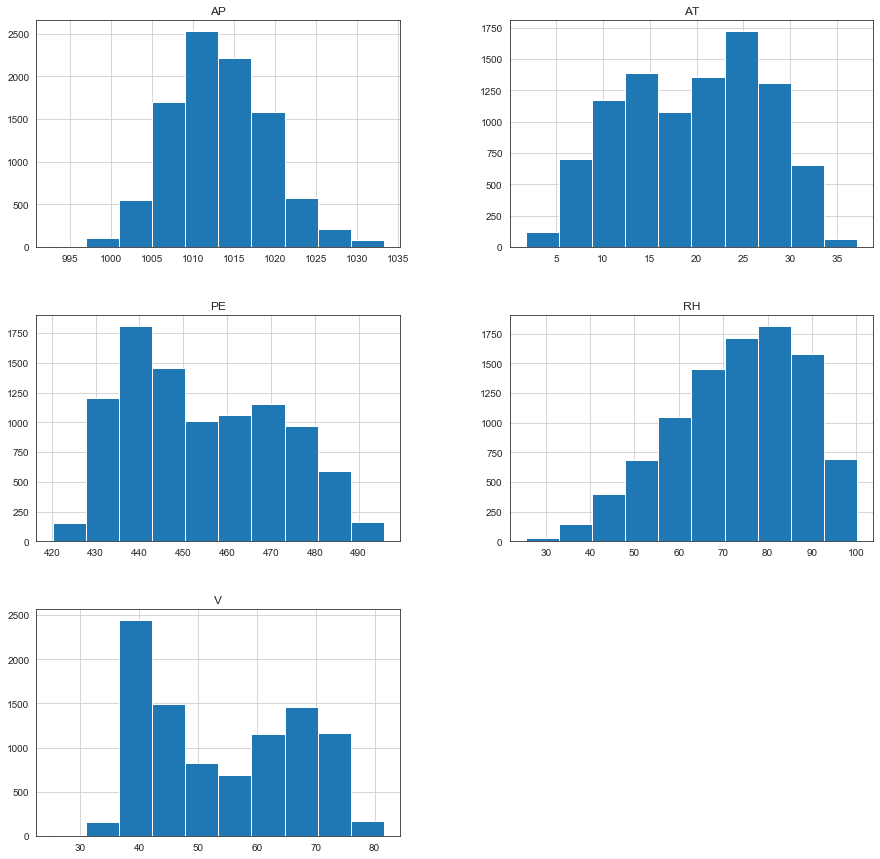

In [10]:
#Check the data
df_power.hist(figsize=(15,15))

[Text(0, 0, 'AT'),
 Text(0, 0, 'V'),
 Text(0, 0, 'AP'),
 Text(0, 0, 'RH'),
 Text(0, 0, 'PE')]

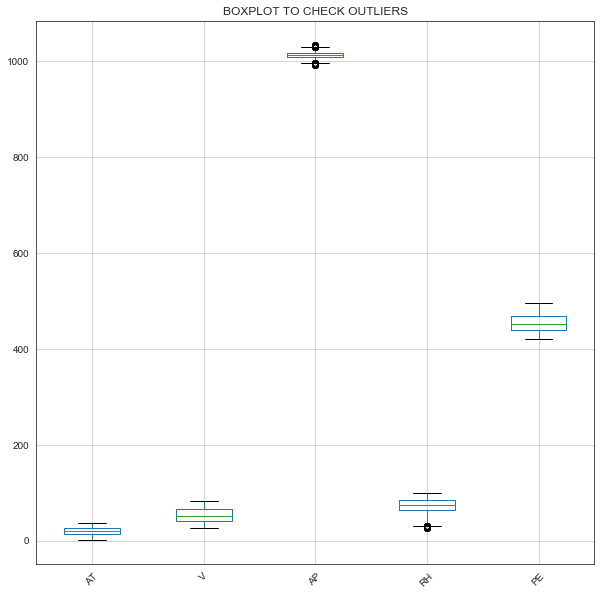

In [11]:
#check for outliers
plt.figure(figsize=(10,10))
ax = df_power.boxplot()
ax.set_title('BOXPLOT TO CHECK OUTLIERS')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [12]:
correlation_matrix = df_power.corr()
display(correlation_matrix)

,AT,V,AP,RH,PE
AT,1.000,0.844,-0.508,-0.543,-0.948
V,0.844,1.000,-0.414,-0.312,-0.870
AP,-0.508,-0.414,1.000,0.100,0.518
RH,-0.543,-0.312,0.100,1.000,0.390
PE,-0.948,-0.870,0.518,0.390,1.000


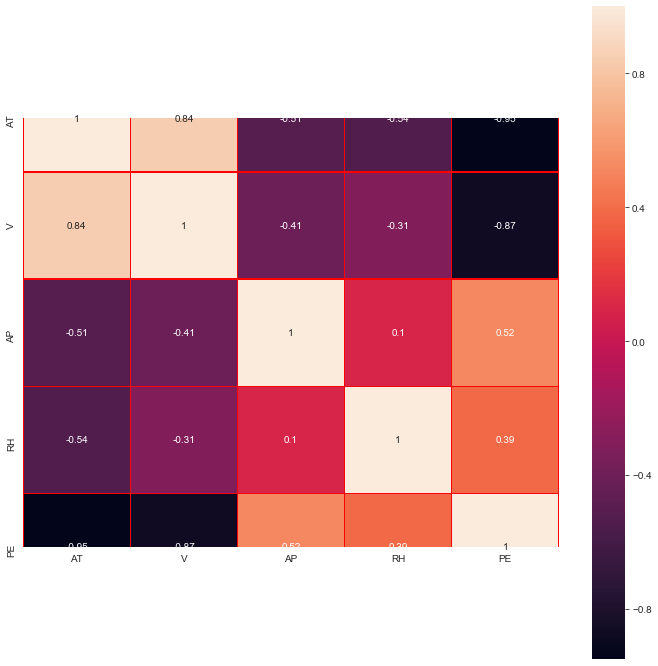

In [13]:
#seaborn heatmap
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df_power.corr(), linewidth=0.2, vmax=1.0, square=True, linecolor='red', annot=True)

## Linear Regression

In [16]:
X = df_power[['AT', 'V', 'AP', 'RH']]
y = df_power.PE

In [19]:
#Splitting the dataset into Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [20]:
#Fitting Multiple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
#Predicting the Test set results
y_pred = regressor.predict(X_test)
y_pred

array([431.42761597, 458.56124622, 462.75264705, ..., 469.51835895,
       442.41759454, 461.88279939])

### Calculating the Coefficients and Intercepts:

In [23]:
#Calculating the Coefficients:
print(regressor.coef_)

[-1.97313099 -0.23649993  0.06387891 -0.15807019]


In [24]:
#Calculating the Intercept
print(regressor.intercept_)

452.8410371616381


In [25]:
#Calculating the R squared value
#R square proves the if the model is a good model or good predictor
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.9325315554761303

#This means our model is a good predictor and successfully trained our model w/ certain predictors and estimated to predict the net hourly electrical energy output (EP) of the plant.

### Another way to evaluate the model

In [27]:
# Write out the model formula.
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form
linear_formula = 'PE ~ AT + V + AP + RH'

# Fit the model to our data using the formula.
lm = smf.ols(formula = linear_formula, data= df_power).fit()

In [28]:
lm.params

Intercept   454.609
AT           -1.978
V            -0.234
AP            0.062
RH           -0.158
dtype: float64

In [29]:
lm.pvalues

Intercept   0.000
AT          0.000
V           0.000
AP          0.000
RH          0.000
dtype: float64

In [63]:
lm.rsquared

0.9286960898122536

In [30]:
lm.conf_int()

,0,1
Intercept,435.500,473.718
AT,-2.007,-1.948
V,-0.248,-0.220
AP,0.044,0.081
RH,-0.166,-0.150


In [31]:
df_power.columns

Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')

## Use KNN(Regression)

In [32]:
#Split dataset
X = df_power[['AT', 'V', 'AP', 'RH']]
y = df_power.PE
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)

In [ ]:
#Rule of thumb: Any algorithm the computes distance or assume normality, scale your features

In [33]:
#Features scaling, we do not scale the y, we only scale data that going in.
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [34]:
#see value of K and it should be odd number
import math
print(len(y_test))
math.sqrt(len(y_test))

1914


43.749285708454714

In [35]:
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=43)
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=43, p=2,
                    weights='uniform')

In [36]:
#Predicting the Test set results
y_pred = knn.predict(X_test)
y_pred

array([433.48813953, 460.06093023, 467.37651163, ..., 469.46953488,
       440.63255814, 461.1355814 ])

In [37]:
#Calculating the R squared value
#R square proves the if the model is a good model or good predictor
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.9421012486631548

In [39]:
#For Classification

In [47]:
#Split dataset
X = df_power[['AT', 'V', 'AP', 'RH']]
y = df_power.PE
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)

In [48]:
#Rule of thumb: Any algorithm the computes distance or assume normality, scale your features

In [49]:
#Features scaling, we do not scale the y, we only scale data that going in.
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [ ]:
#N_neighbors here is 'K', p is the power parameter to define the metric used, which is the 'Euclidean in our case'

In [50]:
#Define the model: Init K-NN
classifier = KNeighborsClassifier(n_neighbors=43, p=2, metric='euclidean')

In [58]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: 0.94 (+/- 0.00)
Weighted Accuracy: 0.95 (+/- 0.00)


In [59]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(knn, X, Y, cv=10)
print((score.mean(), score.std() * 2))

score_w = cross_val_score(knn_w, X, Y, cv=10)
print((score_w.mean(), score_w.std() * 2))

(0.945338668065129, 0.006503395422021445)
(0.9508018760201766, 0.007056111019252526)


In [61]:
# Test your model with different holdout groups.

from sklearn.model_selection import train_test_split
regr = linear_model.LinearRegression()
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(features, target,  test_size=0.4, random_state=20)

print('With 40% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))

print('Testing on Sample: ' + str(regr.fit(features, target).score(features, target)))

With 40% Holdout: 0.9276534792464092
Testing on Sample: 0.9286960898122538


In [62]:
from sklearn.model_selection import cross_val_score
cross_val_score(regr, X_train, y_train, cv=10)

array([0.93524479, 0.92270579, 0.928201  , 0.93564029, 0.91608919,
       0.9341467 , 0.93403347, 0.92878844, 0.93307826, 0.9224376 ])

Linear regression is an example of a parametric
approach because it assumes a linear functional form for f(X),
while K-Nearest Neighbors (KNN), which is
a non-parametric method.

Parametric methods
1. Advantages
    Easy to fit. 
    One needs to estimate a small number of
    coefficients.
    Often easy to interpret.
2. Disadvantages
    They make strong assumptions about the form of f (X).
    Suppose we assume a linear relationship between X and Y but
    the true relationship is far from linear, then the resulting model
    will provide a poor fit to the data, and any conclusions drawn
    from it will be suspect.

Non-parametric models
1. Advantages
    They do not assume an explicit form for f (X), providing a
    more flexible approach.
2. Disadvantages
    They can be often more complex to understand and interpret
    If there is a small number of observations per predictor, then
    parametric methods then to work better.